### Background checks

This nootebook tests the sampling of the background. We simulate only the background and we then fit it, leaving the tilt and normalization parameters free to vary.

In [1]:
from pathlib import Path
import logging
import warnings
import click
import multiprocessing
from itertools import repeat

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.convolution import Tophat2DKernel
from astropy.coordinates import SkyCoord
from astropy.table import Table
# from gammapy.cube import (
#     MapDatasetEventSampler,
# )
from gammapy.data import GTI, Observation, EventList
from gammapy.datasets import MapDataset
from gammapy.detect import LiMaMapEstimator as lima
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.irf import EnergyDispersion2D, load_cta_irfs
from gammapy.makers import MapDatasetMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import Models
from gammapy.utils.table import table_from_row_data
from regions import CircleSkyRegion

import copy
import numpy as np
import astropy.units as u
from astropy.table import Table
import gammapy
from gammapy.data import EventList
from gammapy.maps import MapCoord
from gammapy.modeling.models import BackgroundModel, ConstantTemporalModel
from gammapy.utils.random import get_random_state
import yaml


In [18]:
class MapDatasetEventSampler:
    """Sample events from a map dataset

    Parameters
    ----------
    random_state : {int, 'random-seed', 'global-rng', `~numpy.random.RandomState`}
        Defines random number generator initialisation.
        Passed to `~gammapy.utils.random.get_random_state`.
    """

    def __init__(self, random_state="random-seed"):
        self.random_state = get_random_state(random_state)

    def _sample_coord_time(self, npred, temporal_model, gti):
        n_events = self.random_state.poisson(np.sum(npred.data))

        coords = npred.sample_coord(n_events=n_events, random_state=self.random_state)

        table = Table()
        try:
            energy = coords["energy_true"]
        except KeyError:
            energy = coords["energy"]

        table["ENERGY_TRUE"] = energy
        table["RA_TRUE"] = coords.skycoord.icrs.ra.to("deg")
        table["DEC_TRUE"] = coords.skycoord.icrs.dec.to("deg")

        time_start, time_stop, time_ref = (gti.time_start, gti.time_stop, gti.time_ref)
        time = temporal_model.sample_time(
            n_events, time_start, time_stop, self.random_state
        )
        table["TIME"] = u.Quantity(((time.mjd - time_ref.mjd) * u.day).to(u.s)).to("s")
        return table

    def sample_sources(self, dataset):
        """Sample source model components.

        Parameters
        ----------
        dataset : `~gammapy.cube.MapDataset`
            Map dataset.

        Returns
        -------
        events : `~gammapy.data.EventList`
            Event list
        """
        events_all = []

        for idx, model in enumerate(dataset.models):
            if isinstance(model, BackgroundModel):
                continue

            evaluator = dataset.evaluators.get(model.name)

            evaluator = copy.deepcopy(evaluator)
            evaluator.model.apply_irf["psf"] = False
            evaluator.model.apply_irf["edisp"] = False
            npred = evaluator.compute_npred()

            temporal_model = ConstantTemporalModel()

            table = self._sample_coord_time(npred, temporal_model, dataset.gti)
            table["MC_ID"] = idx + 1
            events_all.append(EventList(table))

        return EventList.stack(events_all)

    def sample_background(self, dataset):
        """Sample background

        Parameters
        ----------
        dataset : `~gammapy.cube.MapDataset`
            Map dataset

        Returns
        -------
        events : `gammapy.data.EventList`
            Background events
        """
        background = dataset.background_model.evaluate()

        temporal_model = ConstantTemporalModel()

        table = self._sample_coord_time(background, temporal_model, dataset.gti)

        table["MC_ID"] = 0
        table.rename_column("ENERGY_TRUE", "ENERGY")
        table.rename_column("RA_TRUE", "RA")
        table.rename_column("DEC_TRUE", "DEC")

        return EventList(table)

    def sample_edisp(self, edisp_map, events):
        """Sample energy dispersion map.

        Parameters
        ----------
        edisp_map : `~gammapy.cube.EDispMap`
            Energy dispersion map
        events : `~gammapy.data.EventList`
            Event list with the true energies

        Returns
        -------
        events : `~gammapy.data.EventList`
            Event list with reconstructed energy column.
        """
        coord = MapCoord(
            {
                "lon": events.table["RA_TRUE"].quantity,
                "lat": events.table["DEC_TRUE"].quantity,
                "energy_true": events.table["ENERGY_TRUE"].quantity,
            },
            frame="icrs",
        )

        coords_reco = edisp_map.sample_coord(coord, self.random_state)
        events.table["ENERGY"] = coords_reco["energy"]
        return events

    def sample_psf(self, psf_map, events):
        """Sample psf map.

        Parameters
        ----------
        psf_map : `~gammapy.cube.PSFMap`
            PSF map.
        events : `~gammapy.data.EventList`
            Event list.

        Returns
        -------
        events : `~gammapy.data.EventList`
            Event list with reconstructed position columns.
        """
        coord = MapCoord(
            {
                "lon": events.table["RA_TRUE"].quantity,
                "lat": events.table["DEC_TRUE"].quantity,
                "energy_true": events.table["ENERGY_TRUE"].quantity,
            },
            frame="icrs",
        )

        coords_reco = psf_map.sample_coord(coord, self.random_state)
        events.table["RA"] = coords_reco["lon"] * u.deg
        events.table["DEC"] = coords_reco["lat"] * u.deg
        return events

    @staticmethod
    def event_list_meta(dataset, observation):
        """Event list meta info.

        Parameters
        ----------
        dataset : `~gammapy.cube.MapDataset`
            Map dataset.
        observation : `~gammapy.data.Observation`
            In memory observation.

        Returns
        -------
        meta : dict
            Meta dictionary.
        """
        # See: https://gamma-astro-data-formats.readthedocs.io/en/latest/events/events.html#mandatory-header-keywords
        meta = {}

        meta["HDUCLAS1"] = "EVENTS"
        meta["EXTNAME"] = 'EVENTS'
        meta[
            "HDUDOC"
        ] = "https://github.com/open-gamma-ray-astro/gamma-astro-data-formats"
        meta["HDUVER"] = "0.2"
        meta["HDUCLASS"] = "GADF"

        meta["OBS_ID"] = observation.obs_id

        meta["TSTART"] = (
            ((observation.tstart.mjd - dataset.gti.time_ref.mjd) * u.day).to(u.s).value
        )
        meta["TSTOP"] = (
            ((observation.tstop.mjd - dataset.gti.time_ref.mjd) * u.day).to(u.s).value
        )
        meta["ONTIME"] = observation.observation_time_duration.to("s").value
        meta["LIVETIME"] = observation.observation_live_time_duration.to("s").value
        meta["DEADC"] = observation.observation_dead_time_fraction

        meta["RA_PNT"] = observation.pointing_radec.icrs.ra.deg
        meta["DEC_PNT"] = observation.pointing_radec.icrs.dec.deg

        meta["EQUINOX"] = "J2000"
        meta["RADECSYS"] = "icrs"
        # TO DO: these keywords should be taken from the IRF of the dataset
        meta["ORIGIN"] = "Gammapy"
        meta["TELESCOP"] = ""
        meta["INSTRUME"] = ""
        #
        meta["CREATOR"] = "Gammapy {}".format(gammapy.__version__)

        #        TO COMPLETE
        #        meta["OBSERVER"] = ""
        #        meta["CREATED"] = ""
        #        meta["OBJECT"] = ""
        #        meta["RA_OBJ"] = ""
        #        meta["DEC_OBJ"] = ""
        #        meta["OBS_MODE"] = ""
        #        meta["EV_CLASS"] = ""
        #        meta["TELAPSE"] = ""
        #
        #        meta["MJDREFI"] = int(dataset.gti.time_ref.mjd)
        #        meta["MJDREFF"] = dataset.gti.time_ref.mjd % 1
        #        meta["TIMEUNIT"] = "s"
        #        meta["TIMESYS"] = "TT"
        #        meta["TIMEREF"] = "LOCAL"
        #        #         meta["DATE-OBS"] = dataset.gti.time_start.isot[0][0:10]
        #        #         meta["DATE-END"] = dataset.gti.time_stop.isot[0][0:10]
        #        meta["TIME-OBS"] = dataset.gti.time_start.isot[0]
        #        meta["TIME-END"] = dataset.gti.time_stop.isot[0]
        #

        meta["GEOLON"] = 0
        meta["GEOLAT"] = 0
        meta["ALTITUDE"] = 0

        for idx, model in enumerate(dataset.models):
            meta["MID{:05d}".format(idx + 1)] = idx + 1
            meta["MMN{:05d}".format(idx + 1)] = model.name

        return meta

    def run(self, dataset, observation=None):
        """Run the event sampler, applying IRF corrections.

        Parameters
        ----------
        dataset : `~gammapy.cube.MapDataset`
            Map dataset
        observation : `~gammapy.data.Observation`
            In memory observation.
        edisp : Bool
            It allows to include or exclude the Edisp in the simulation.

        Returns
        -------
        events : `~gammapy.data.EventList`
            Event list.
        """
        try:
            dataset.models[1]
            events_src = self.sample_sources(dataset)

            if dataset.psf:
                events_src = self.sample_psf(dataset.psf, events_src)
            else:
                events_src.table["RA"] = events_src.table["RA_TRUE"]
                events_src.table["DEC"] = events_src.table["DEC_TRUE"]

            if dataset.edisp:
                events_src = self.sample_edisp(dataset.edisp, events_src)
            else:
                events_src.table["ENERGY"] = events_src.table["ENERGY_TRUE"]

            if dataset.background_model:
                events_bkg = self.sample_background(dataset)
                events = EventList.stack([events_bkg, events_src])
            else:
                events = events_src

        except:
            if dataset.background_model:
                events_bkg = self.sample_background(dataset)
                events = EventList.stack([events_bkg])

        events.table["EVENT_ID"] = np.arange(len(events.table))
        events.table.meta = self.event_list_meta(dataset, observation)

        return events


In [3]:
log = logging.getLogger(__name__)

#### Define the configuration parameters

In [28]:
BASE_PATH = Path("../male.py").parent

AVAILABLE_MODELS = ["background"]

DPI = 120

# observation config
IRF_FILE = "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
#IRF_FILE = "$GAMMAPY_DATA/cta-prod3b/caldb/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"

POINTING = SkyCoord(0.0, 0.0, frame="galactic", unit="deg")
LIVETIME = 1 * u.hr
GTI_TABLE = GTI.create(start=0 * u.s, stop=LIVETIME.to(u.s))

# dataset config
ENERGY_AXIS = MapAxis.from_energy_bounds("0.1 TeV", "100 TeV", nbin=10, per_decade=True)
ENERGY_AXIS_TRUE = MapAxis.from_energy_bounds("0.03 TeV", "300 TeV", nbin=20, per_decade=True, name="energy_true")
MIGRA_AXIS = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

WCS_GEOM = WcsGeom.create(
    skydir=POINTING, width=(4, 4), binsz=0.02, frame="galactic", axes=[ENERGY_AXIS]
)

WCS_GEOM_fit = WcsGeom.create(
    skydir=POINTING, width=(4, 4), binsz=0.1, frame="galactic", axes=[ENERGY_AXIS]
)

#### Define some useful functions

In [31]:
def get_filename_dataset(livetime):
    filename = f"data/dataset_{livetime.value:.0f}{livetime.unit}.fits.gz"
    return BASE_PATH / filename


def get_filename_events(filename_dataset, filename_model, obs_id):
    obs_id=int(obs_id)
    model_str = filename_model.name.replace(filename_model.suffix, "")
    filename_events = filename_dataset.name.replace("dataset", "events")
    filename_events = BASE_PATH / f"data/models/{model_str}/" / filename_events
    filename_events = filename_events.name.replace(".fits.gz", f"_{obs_id:04d}.fits.gz")
    path = BASE_PATH / f"data/models/{model_str}/" / filename_events
    return path


def get_filename_best_fit_model(filename_model, obs_id, livetime):
    obs_id=int(obs_id)
    model_str = filename_model.name.replace(filename_model.suffix, "")
    
    path = BASE_PATH / f"results/models/{model_str}/fit_{livetime.value:.0f}{livetime.unit}/covariance"
    path.mkdir(exist_ok=True, parents=True)
    path = BASE_PATH / f"results/models/{model_str}/plots_{livetime.value:.0f}{livetime.unit}"
    path.mkdir(exist_ok=True, parents=True)
    
    filename = f"results/models/{model_str}/fit_{livetime.value:.0f}{livetime.unit}/best-fit-model_{obs_id:04d}.yaml"
    return BASE_PATH / filename


def get_filename_covariance(filename_best_fit_model):
    filename = filename_best_fit_model.name
    filename = filename.replace("best-fit-model", "covariance")
    filename = filename.replace(".yaml", ".txt")
    return filename_best_fit_model.parent / "covariance" / filename

def read_best_fit_model(filename):
    log.info(f"Reading {filename}")
    model_best_fit = Models.read(filename)

    path = get_filename_covariance(filename)
    log.info(f"Reading {path}")
    pars = model_best_fit.parameters
    pars.covariance = np.loadtxt(str(path))

    if model_best_fit[0].tag  == 'SkyDiffuseCube':
        spectral_model_best_fit = model_best_fit[0]
        covar = pars.get_subcovariance(spectral_model_best_fit.parameters)
        spectral_model_best_fit.parameters.covariance = covar
            
#        spatial_model_best_fit = model_best_fit[0].spatial_model
#        covar = pars.get_subcovariance(spatial_model_best_fit.parameters)
#        spatial_model_best_fit.parameters.covariance = covar

    else:
        spectral_model_best_fit = model_best_fit[0].spectral_model
        covar = pars.get_subcovariance(spectral_model_best_fit.parameters)
        spectral_model_best_fit.parameters.covariance = covar
        
        spatial_model_best_fit = model_best_fit[0].spatial_model
        covar = pars.get_subcovariance(spatial_model_best_fit.parameters)
        spatial_model_best_fit.parameters.covariance = covar

    return model_best_fit


def parse_obs_ids(obs_ids_str, model):
    if ":" in obs_ids_str:
        start, stop = obs_ids_str.split(":")
        obs_ids = np.arange(int(start), int(stop))
    elif "," in obs_ids_str:
        obs_ids = [int(_) for _ in obs_ids_str.split(",")]
    elif obs_ids_str == "all":
        n_obs = len(list(BASE_PATH.glob(f"data/models/{model}/events_*.fits.gz")))
        obs_ids = np.arange(n_obs)
    else:
         obs_ids = [int(obs_ids_str)]
    return obs_ids

def read_dataset(filename_dataset, filename_model, obs_id):
    log.info(f"Reading {filename_dataset}")
    dataset = MapDataset.read(filename_dataset)

    filename_events = get_filename_events(filename_dataset, filename_model, obs_id)
    log.info(f"Reading {filename_events}")
    events = EventList.read(filename_events)

    counts = Map.from_geom(WCS_GEOM)
    counts.fill_events(events)
    dataset.counts = counts
    return dataset

def read_dataset_for_fit(filename_dataset, filename_dataset_fit, filename_model, obs_id):
    log.info(f"Reading {filename_dataset_fit}")
    dataset = MapDataset.read(filename_dataset_fit)

    filename_events = get_filename_events(filename_dataset, filename_model, obs_id)
    log.info(f"Reading {filename_events}")
    events = EventList.read(filename_events)

    counts = Map.from_geom(WCS_GEOM_fit)
    counts.fill_events(events)
    dataset.counts = counts
    return dataset

In [6]:
def prepare_dataset(filename_dataset):
    """Prepare dataset for a given skymodel."""
    log.info(f"Reading {IRF_FILE}")
    irfs = load_cta_irfs(IRF_FILE)
    observation = Observation.create(
        obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
    )

    empty = MapDataset.create(WCS_GEOM, energy_axis_true=ENERGY_AXIS_TRUE, migra_axis=MIGRA_AXIS)
    maker = MapDatasetMaker(selection=["exposure", "background"])
    dataset = maker.run(empty, observation)

    filename_dataset.parent.mkdir(exist_ok=True, parents=True)
    log.info(f"Writing {filename_dataset}")
    dataset.write(filename_dataset, overwrite=True)

In [7]:
def prepare_dataset_fit(filename_dataset):
    """Prepare dataset for a given skymodel."""
    log.info(f"Reading {IRF_FILE}")
    irfs = load_cta_irfs(IRF_FILE)
    observation = Observation.create(
        obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
    )

    empty = MapDataset.create(WCS_GEOM_fit, energy_axis_true=ENERGY_AXIS_TRUE, migra_axis=MIGRA_AXIS)
    maker = MapDatasetMaker(selection=["exposure", "background"])
    dataset = maker.run(empty, observation)

    filename_dataset.parent.mkdir(exist_ok=True, parents=True)
    log.info(f"Writing {filename_dataset}")
    dataset.write(filename_dataset, overwrite=True)

In [8]:
def simulate_events(filename_model, filename_dataset, nobs):
    """Simulate events of the bkg and dataset.

    Parameters
    ----------
    filename_model : str
        Filename of the model definition.
    filename_dataset : str
        Filename of the dataset to use for simulation.
    nobs : int
        Number of obervations to simulate.
    """
    log.info(f"Reading {IRF_FILE}")
    irfs = load_cta_irfs(IRF_FILE)

    log.info(f"Reading {filename_dataset}")
    dataset = MapDataset.read(filename_dataset)

    sampler = MapDatasetEventSampler(random_state=0)

    for obs_id in np.arange(nobs):
        observation = Observation.create(
            obs_id=obs_id, pointing=POINTING, livetime=LIVETIME, irfs=irfs
        )

        events = sampler.run(dataset, observation)

        path = get_filename_events(filename_dataset, filename_model, obs_id)
        log.info(f"Writing {path}")
        path.parent.mkdir(exist_ok=True, parents=True)
        events.table.write(str(path), overwrite=True)
        

In [9]:
def fit_model(filename_model, filename_dataset, obs_id, filename_dataset_fit=None):
    """Fit the events using a model.

    Parameters
    ----------
    filename_model : str
        Filename of the model definition.
    filename_dataset : str
        Filename of the dataset to use for simulation.
    obs_id : int
        Observation ID.
    """
    if filename_dataset_fit is not None:
        dataset = read_dataset_for_fit(filename_dataset, filename_dataset_fit, filename_model, obs_id)
    else:
        dataset = read_dataset(filename_dataset, filename_model, obs_id)

    dataset.background_model.parameters["norm"].frozen = False
    dataset.background_model.parameters["tilt"].frozen = False
    
    fit = Fit([dataset])

#     result = fit.run(optimize_opts={"print_level": 1})
    result = fit.run()

    log.info(f"Fit info: {result}")
    path = get_filename_best_fit_model(filename_model, obs_id, LIVETIME)
    log.info(f"Writing {path}")
    dataset.models.write(str(path), overwrite=True)
    path = get_filename_covariance(path)

    log.info(f"Writing {path}")

    # TODO: exclude background parameters for now, as they are fixed anyway
    covariance = result.parameters.get_subcovariance(dataset.models.parameters)
    np.savetxt(path, covariance)


In [10]:
def fit_gather(model_name, livetime):
    rows = []

    path = (BASE_PATH / f"results/models/{model_name}/fit_{livetime.value:.0f}{livetime.unit}")

    for filename in path.glob("*.yaml"):
        yaml_str = Path(filename).read_text()
        model_best_fit = yaml.safe_load(yaml_str)
        path = get_filename_covariance(filename)
        covariance = np.loadtxt(str(path))

        row = {}

        for i in np.arange(len(model_best_fit['components'][0]['parameters'])):
            name=model_best_fit['components'][0]['parameters'][i]['name']
            value=model_best_fit['components'][0]['parameters'][i]['value']
            row[name] = value
            row[name + "_err"] = covariance[i,i]**0.5

        rows.append(row)

    table = table_from_row_data(rows)
    name = f"fit-results-all_{livetime.value:.0f}{livetime.unit}"
    filename = BASE_PATH / f"results/models/{model_name}/{name}.fits.gz"
    log.info(f"Writing {filename}")
    table.write(str(filename), overwrite=True)
    

In [20]:
def plot_pull_distribution(model_name, livetime):
    name = f"fit-results-all_{livetime.value:.0f}{livetime.unit}"
    filename = BASE_PATH / f"results/models/{model_name}/{name}.fits.gz"
    results = Table.read(str(filename))

    dataset = MapDataset.read(filename_dataset)
    dataset.background_model.parameters["tilt"].frozen = False
    model_ref = dataset.models
    names = [name for name in results.colnames if "err" not in name]

    plots = f"plots_{livetime.value:.0f}{livetime.unit}"
    for name in names:
        # TODO: report mean and stdev here as well
        values = results[name]
        values_err = results[name + "_err"]
        par = model_ref.parameters[name]

        if par.frozen:
            log.info(f"Skipping frozen parameter: {name}")
            continue

        pull = (values - par.value) / values_err

#        print("Number of fits beyond 5 sigmas: ",(np.where( (pull<-5) )))
        plt.hist(pull, bins=21, density=True, range=(-5,5))
        plt.xlim(-5, 5)
        plt.xlabel("(value - value_true) / error")
        plt.ylabel("PDF")
        plt.title(f"Pull distribution for {model_name}: {name} ")
        filename = f"results/models/{model_name}/{plots}/pull-distribution-{name}.png"
        save_figure(filename)


def save_figure(filename):
    path = BASE_PATH / filename
    path.parent.mkdir(parents=True, exist_ok=True)
    log.info(f"Writing {path}")
    plt.savefig(path, dpi=DPI)
    plt.clf()
    plt.close()


### TEST

In [30]:
change_binning_fit_dataset=True

model = 'background'
models = [model]
filename_model = BASE_PATH / f"models/{model}.yaml"
filename_dataset = get_filename_dataset(LIVETIME)
filename_dataset_fit = BASE_PATH / "data/dataset_1h_fit.fits.gz"

obs_ids=1000

prepare_dataset(filename_dataset)
prepare_dataset_fit(filename_dataset_fit)

for model in models:
#     simulate_events(filename_model=filename_model, filename_dataset=filename_dataset, nobs=obs_ids)
    obs_ids = f"0:{obs_ids}"
    obs_ids = parse_obs_ids(obs_ids, model)
    with multiprocessing.Pool(processes=4) as pool:
        if change_binning_fit_dataset==False:
            args = zip(repeat(filename_model), repeat(filename_dataset), obs_ids)
        else:
            args = zip(repeat(filename_model), repeat(filename_dataset), obs_ids, repeat(filename_dataset_fit))
        results = pool.starmap(fit_model, args)

    fit_gather(model,LIVETIME)
    plot_pull_distribution(model, LIVETIME)

(array([  1.,   1.,   1.,   2.,   1.,   0.,   3.,   3.,   0.,   0.,   1.,
          5.,   2.,   3.,   2.,   0.,   1.,   4.,   1.,   4.,   7.,   2.,
          4.,   3.,   2.,   3.,   4.,   4.,   5.,   2.,   8.,   3.,   1.,
          2.,   5.,   6.,   8.,   5.,   2.,  10.,   2.,   7.,   2.,   6.,
          5.,   5.,   5.,  11.,   5.,   3.,   9.,   8.,   7.,   5.,   3.,
         13.,  16.,   6.,  15.,   9.,  13.,  14.,  13.,   8.,   5.,   6.,
         10.,  14.,  11.,  12.,  10.,  10.,   8.,   9.,  10.,  14.,  19.,
         11.,   5.,  13.,   5.,  12.,  16.,  13.,  13.,  13.,   7.,  17.,
         19.,  18.,  10.,  13.,  19.,  10.,  16.,  13.,   9.,  16.,  14.,
         12.,  16.,  15.,  18.,   8.,  16.,  22.,  15.,  12.,  18.,  24.,
         12.,  15.,  20.,  14.,  16.,  23.,  19.,  18.,  17.,  20.,  19.,
         19.,  19.,  25.,  18.,  18.,  25.,  26.,  23.,  29.,  16.,  12.,
         18.,  24.,  20.,  16.,  20.,  18.,  22.,  19.,  18.,  22.,  32.,
         23.,  24.,  20.,  20.,  20., 

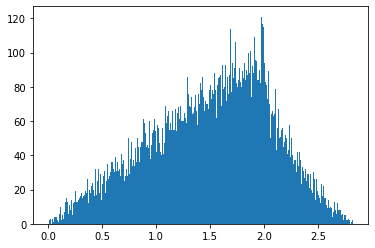

In [43]:
model = 'background'
obsid=0
filename_events = BASE_PATH / f"data/models/{model}/events_{LIVETIME.value:.0f}{LIVETIME.unit}_{obsid:04d}.fits.gz"
events = EventList.read(filename_events)

evt_pos = SkyCoord(events.table['RA'], events.table['DEC'], frame='icrs')
sep = POINTING.separation(evt_pos).value

plt.hist(sep, bins=1000)


In [40]:
sep

array([1.74941648, 2.2281028 , 1.97197328, ..., 1.20249898, 0.5554091 ,
       0.21984091])